# Imports

In [22]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import f1_score,recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
import optuna
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:
features=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

df=pd.read_csv('../creditcard.csv')
df=df.rename(columns={'Class':'target'})

In [7]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optuna Tuning

In [24]:
def objective(trial: int, X_train: pd.DataFrame, y_train:pd.DataFrame):
    
    """ Simple function to tune hyperparameters of each XGBoost that will constitute to the final model """
    
    params={'lambda': trial.suggest_loguniform('lambda', 1e-2, 5.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 5.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.012,0.014,0.016,0.018, 0.02,0.05]),
        'n_estimators': trial.suggest_int('n_estimators',50,500),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,5,7,9,11]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
    
    f1=[]
    recall=[]
    
    kf= KFold(n_splits=3)
    
     
    for train_idx,test_idx in kf.split(X_train,y_train):
        
        X_train_tuning,y_train_tuning= X_train.iloc[train_idx],y_train.iloc[train_idx]

        X_test_tuning,y_test_tuning= X_train.iloc[test_idx],y_train.iloc[test_idx]
        
        model=XGBClassifier(**params,n_jobs=-1)
        
        model.fit(X_train_tuning,y_train_tuning)
        
        predictions=model.predict(X_test_tuning)
        
        f1.append(f1_score(y_test_tuning,predictions))
        
        #recall.append(recall_score(y_test_tuning,predictions))
        
    return np.mean(f1)

# Create model

In [25]:
def create_xgb(X_train: pd.DataFrame, y_train: pd.DataFrame):
    
    """ Takes as input the training set composed of X_train and y_train. 
    It returns an xgboost model tuned with the specified training set. """
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
    
    params=study.best_params
           
    model=XGBClassifier(**params,n_jobs=-1)
    
    model.fit(X_train,y_train,verbose=0)
        
    return model

# Balance Cascade algorithm

In [26]:
def balancecascade(train: pd.DataFrame,features: list, n_estimators: int):
    
    """ Simple implementation of the BalanceCascade algorithm. 
    It takes as input a training set, the differetn features used 
    to train the model, and the number of estimators. The only small 
    trick is that instead of throwing all correctly classified samples 
    of the majority class, it throws a unique percentage of it at each iteration. 
    This process is not random, it throws the easiest samples to predict.
    Thus, we do not lose all the correctly classified samples.
    """
    
    train_maj= train[train.target==0]
    train_min= train[train.target==1]
    
    n_maj= len(train_maj)
    n_min= len(train_min)
    
    ratio=n_min/n_maj
    
    keep_rate=np.power(ratio, 1/(n_estimators-1))
    
    n_models=0
    model_list=[]
    
    while len(train_maj)>len(train_min):
        
        train=pd.concat([train_maj,train_min],axis=0)
        
        X_train,y_train=train[features],train.target
        
        undersampler=RandomUnderSampler(sampling_strategy=1, random_state=randint(0,10000))
        X_train_rus,y_train_rus=undersampler.fit_resample(X_train,y_train)
        
        model_list.append(create_xgb(X_train_rus, y_train_rus))
                          
        y_probs=0
                          
        for model in model_list:
            
            y_probs+=model.predict_proba(train_maj[features])[:,1]
        
        y_probs=y_probs/len(model_list)
                          
        train_maj['proba']=y_probs
                          
        train_maj=train_maj.sort_values('proba',ascending=False)[:int(keep_rate*len(train_maj)+1)]
        
        n_models+=1
        
        print(f'Model {n_models} done!')
        
        
    return model_list



# Find the best treshold

In [27]:
def tresholds(y_test: pd.DataFrame, y_preds_proba: np.array):
    
    """ Simple function to plot the confusion matrix for 6 different tresholds """
    
    i=1
    plt.figure(figsize=(30,30))
    
    for treshold in [0.35,0.4,0.45,0.5,0.55,0.6] :
        y_preds_int=(y_preds_proba>treshold).astype(int)
        plt.subplot(3,3,i)
        sns.heatmap(confusion_matrix(y_test,y_preds_int),annot=True,cmap="YlGnBu",annot_kws={"fontsize":50})
        plt.title(f'Treshold {treshold} | Recall: {np.round(recall_score(y_test,y_preds_int),3)}',fontsize=30)
        
        i+=1
        
    plt.tight_layout()
    sns.set(font_scale=1.4)
    plt.show()

# Cross validation strategy

In [28]:
def cross_val(df: pd.DataFrame,features: list, istresh: bool=False):
    
    """ Time series cross validation function. """
    
    train=df[:200000]
    test=df[200000:]
    
    models=balancecascade(train= train, features= features, n_estimators=10)
    
    X_test,y_test= test[features],test.target
        
    y_preds_proba=0
    
    for model in models:
        
        y_preds_proba+=model.predict_proba(X_test)[:,1]
        
    y_preds_proba=y_preds_proba/len(models)
    
    if istresh:
        
        tresholds(y_test,y_preds_proba)
        
    else: 
        
        y_preds=(y_preds_proba>0.5).astype(int)
    
        print('\n')
        print(recall_score(y_test,y_preds))
        print('\n')
        print(confusion_matrix(y_test,y_preds))
    
    
    return y_preds_proba,models
        

C:\Users\gaeta\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model 1 done!
Model 2 done!
Model 3 done!
Model 4 done!
Model 5 done!
Model 6 done!
Model 7 done!
Model 8 done!
Model 9 done!
Model 10 done!


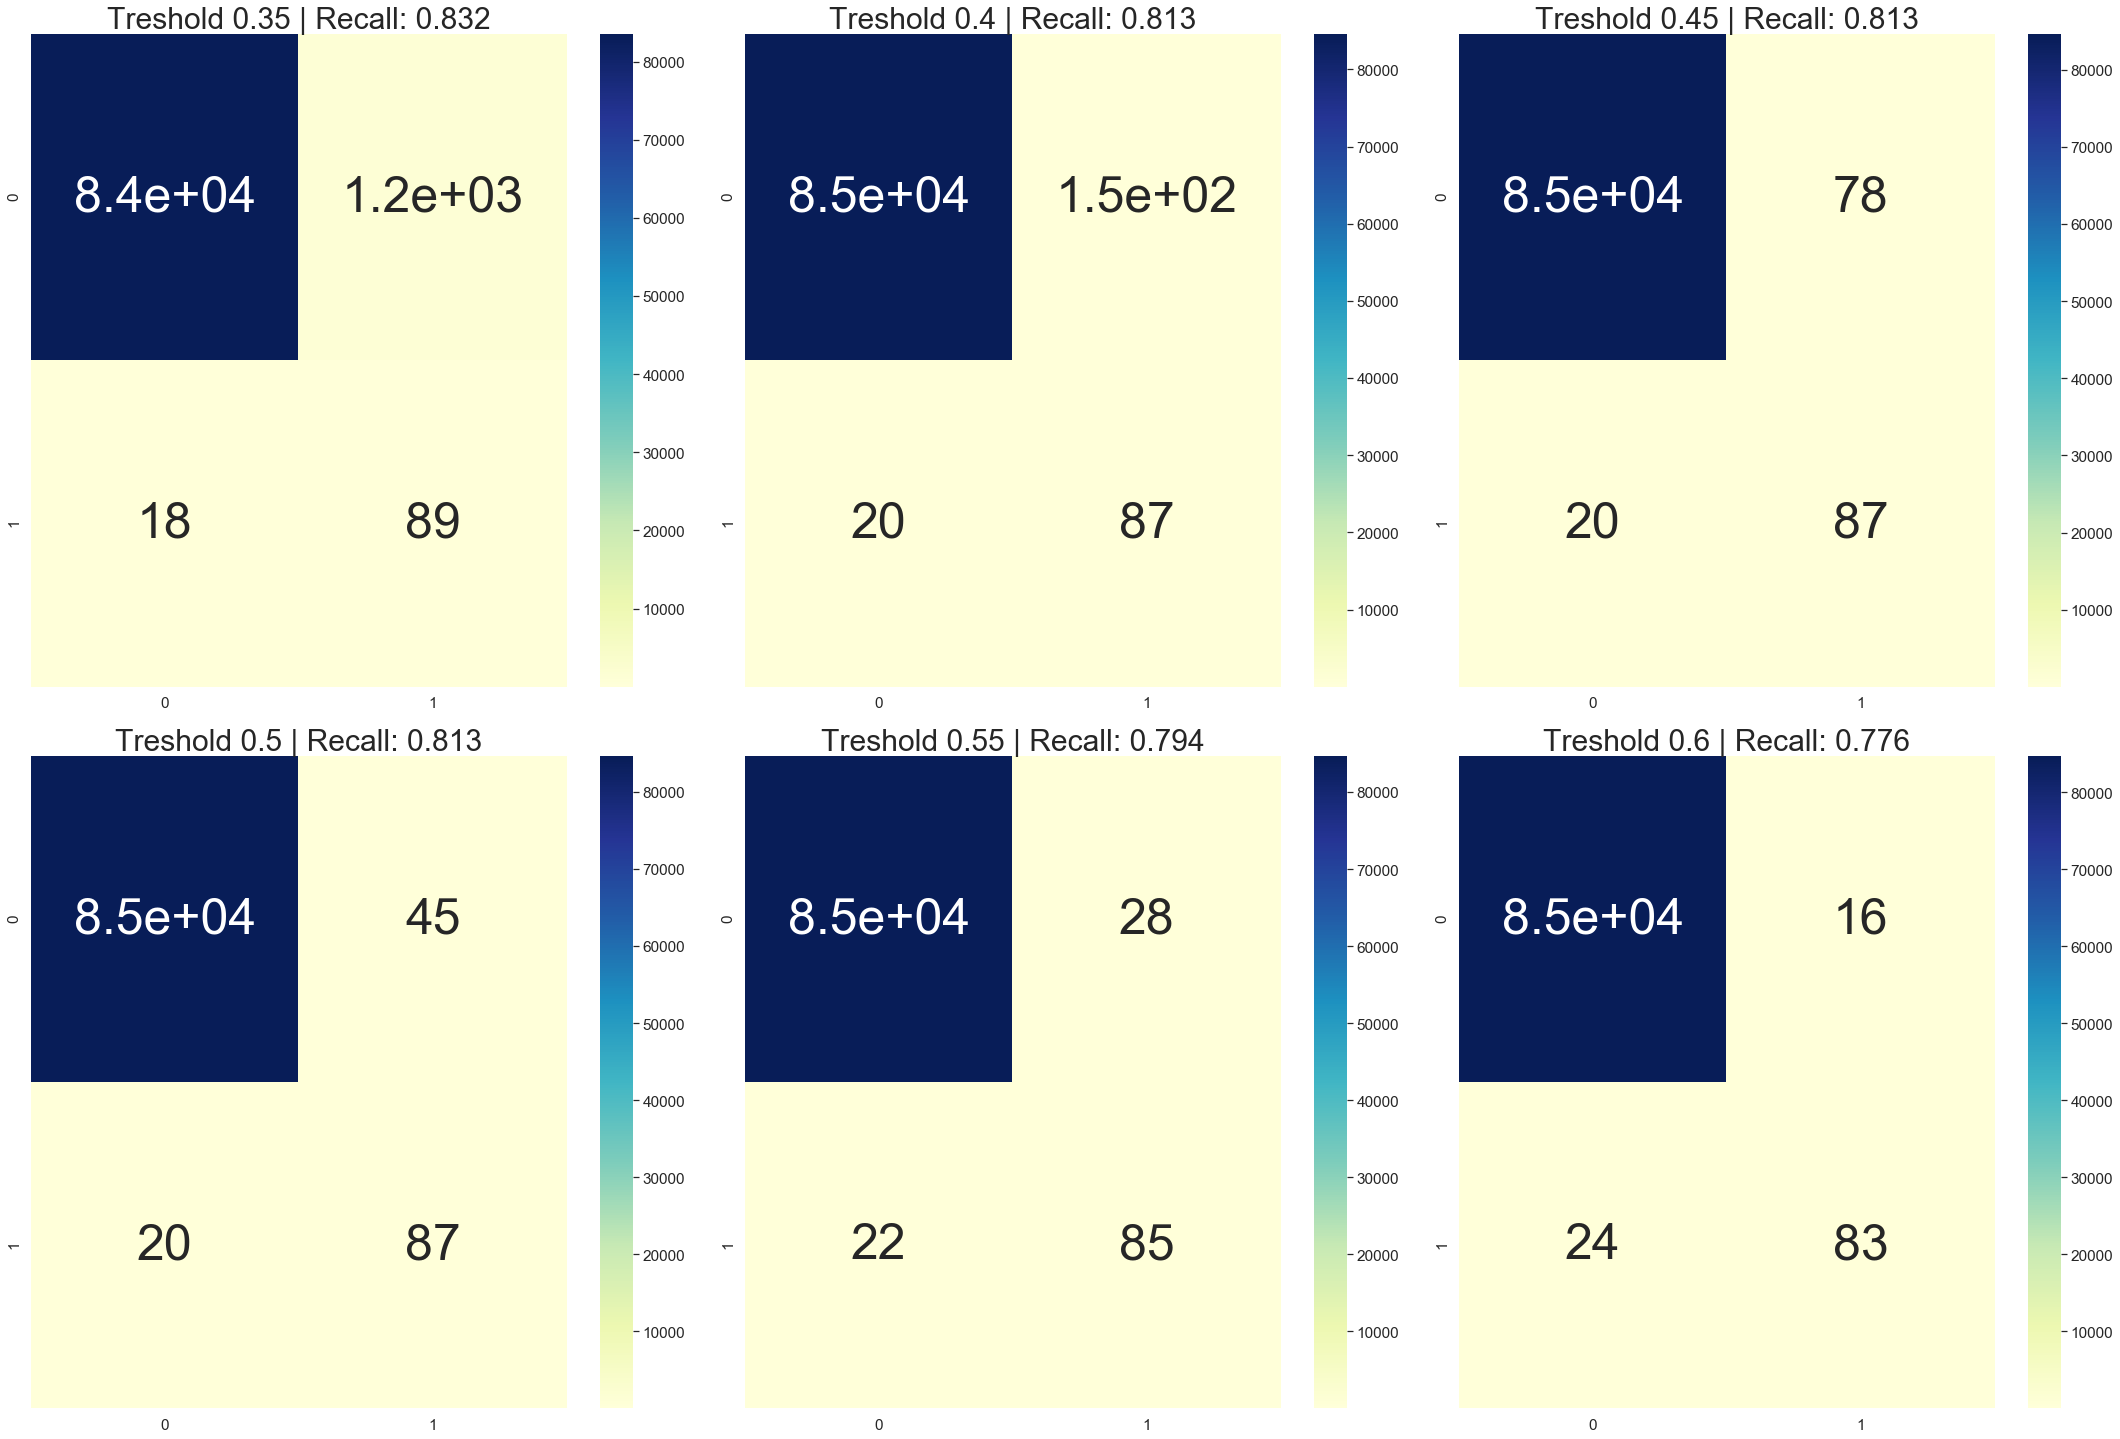

In [29]:
y_preds_proba,models=cross_val(df, features, istresh=True)

In [75]:
models=cross_val(df,features)

C:\Users\gaeta\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 done!
2 done!
3 done!
4 done!
5 done!
6 done!
7 done!
8 done!
9 done!
10 done!


0.8130841121495327


[[84645    55]
 [   20    87]]
